## 1. Feature Engineering

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm 
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Read the file
df = pd.read_csv('/Users/dianaterraza/Desktop/portfolio_project/notebooks/processed_data.csv')

# Display the first few rows of the dataframe
df.head()

,DATE,SGD_USD,CNY_USD
0,2000-01-03,1.6563,8.2798
1,2000-01-04,1.6535,8.2799
2,2000-01-05,1.6560,8.2798
3,2000-01-06,1.6655,8.2797
4,2000-01-07,1.6625,8.2794


In [12]:
df.head()

,DATE,SGD_USD,CNY_USD
0,2000-01-03,1.6563,8.2798
1,2000-01-04,1.6535,8.2799
2,2000-01-05,1.6560,8.2798
3,2000-01-06,1.6655,8.2797
4,2000-01-07,1.6625,8.2794


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5217 entries, 0 to 5216
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     5217 non-null   object 
 1   SGD_USD  5217 non-null   float64
 2   CNY_USD  5217 non-null   float64
dtypes: float64(2), object(1)
memory usage: 122.4+ KB


In [14]:
# Create a copy to work with
df_model = df.copy()

# Handle any missing values
df_model['SGD_USD'] = df_model['SGD_USD'].fillna(method='ffill')

/var/folders/p6/1v6w0vgj3d951b4r8sgj0lgw0000gn/T/ipykernel_8424/2395012321.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_model['SGD_USD'] = df_model['SGD_USD'].fillna(method='ffill')


para sarima no es necesario lags, solo para xgboost 
lags vectores secuenciales, chunks al modelo para q aprenda de los patrones

In [15]:
# 1.1 Creating lag features (past values)
for lag in [1, 3, 7, 14, 21, 30]:
    df_model[f'lag_{lag}d'] = df_model['SGD_USD'].shift(lag)

# 1.2 Percentage changes
df_model['pct_change_1d'] = df_model['SGD_USD'].pct_change() * 100
df_model['returns'] = np.log(df_model['SGD_USD'] / df_model['SGD_USD'].shift(1))

In [16]:
# 1.3 Moving averages
for window in [7, 14, 30, 90]:
    df_model[f'ma_{window}d'] = df_model['SGD_USD'].rolling(window=window).mean()
    
    # Relative position to moving average
    df_model[f'ma_diff_{window}d'] = df_model['SGD_USD'] - df_model[f'ma_{window}d']
    df_model[f'ma_diff_pct_{window}d'] = (df_model['SGD_USD'] / df_model[f'ma_{window}d'] - 1) * 100


In [17]:
# 1.4 Volatility metrics
for window in [7, 14, 30, 90]:
    df_model[f'volatility_{window}d'] = df_model['pct_change_1d'].rolling(window=window).std()

# 1.5 Momentum indicators
for window in [7, 14, 30]:
    df_model[f'momentum_{window}d'] = df_model['SGD_USD'] / df_model['SGD_USD'].shift(window) - 1

# 1.6 Calendar features
df_model['day_of_week'] = df_model.index.dayofweek
df_model['month'] = df_model.index.month
df_model['quarter'] = df_model.index.quarter
df_model['year'] = df_model.index.year

AttributeError: 'RangeIndex' object has no attribute 'dayofweek'

In [18]:
df.head()

,DATE,SGD_USD,CNY_USD
0,2000-01-03,1.6563,8.2798
1,2000-01-04,1.6535,8.2799
2,2000-01-05,1.6560,8.2798
3,2000-01-06,1.6655,8.2797
4,2000-01-07,1.6625,8.2794


##  2. Split the data in Train and Test

In [19]:
# Split data into training and testing sets (80/20 split)
train_size = int(len(df_model) * 0.8)
train = df_model[:train_size]
test = df_model[train_size:]

# Define target and features
target_col = 'SGD_USD'
feature_cols = [col for col in df_model.columns if col != target_col]

X_train = train[feature_cols]
y_train = train[target_col]
X_test = test[feature_cols]
y_test = test[target_col]

### How to Know if Seasonality Is Present

1. Visual Inspection
Plot the time series using matplotlib or plotly.

Look for repeating patterns at regular intervals (daily, weekly, monthly, etc.).

In [20]:
# Split data into training and testing sets (80/20 split)
train_size = int(len(df_model) * 0.8)
train = df_model[:train_size]
test = df_model[train_size:]

# Define target and features
target_col = 'SGD_USD'
feature_cols = [col for col in df_model.columns if col != target_col]

X_train = train[feature_cols]
y_train = train[target_col]
X_test = test[feature_cols]
y_test = test[target_col]

<Axes: title={'center': 'Time Series Plot'}>

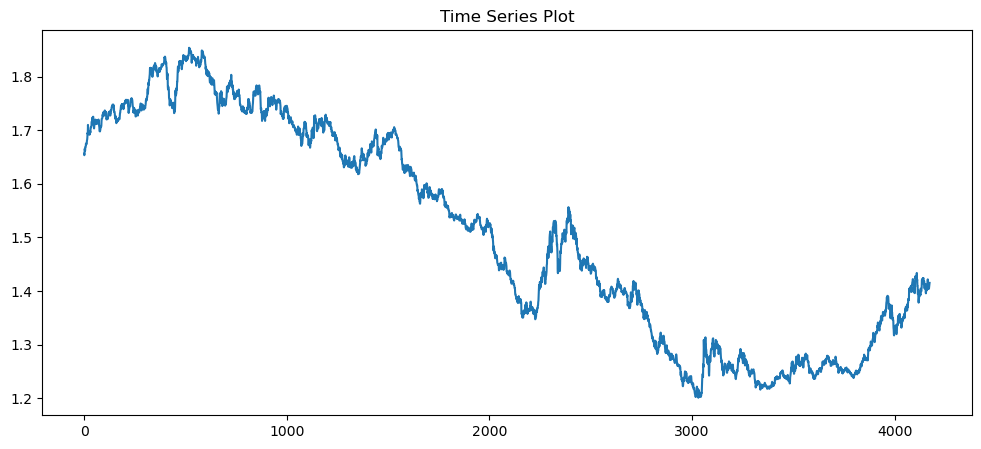

In [21]:
train[target_col].plot(figsize=(12, 5), title='Time Series Plot')


2. Decompose the Time Series

Use seasonal decomposition to split the data into trend, seasonality, and residual components:



In [22]:
# Drop rows with NaN values (created due to lag features)
df_model = df_model.dropna()

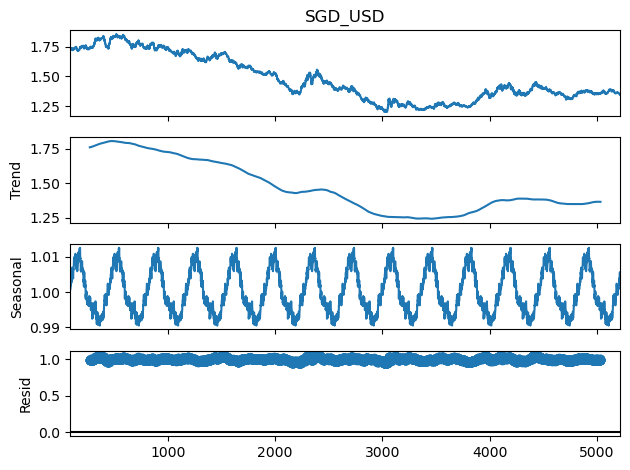

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_model['SGD_USD'], model='multiplicative', period=365)
df_model['seasonal'] = decomposition.seasonal
df_model['trend'] = decomposition.trend
df_model['residual'] = decomposition.resid
decomposition.plot()
plt.show()

What the Decomposition Plot Shows:
* Trend: There is a clear, smooth long-term downward trend from around 2001 to 2018.

* Seasonality: Strong, repeating yearly seasonal patterns are clearly visible in the "Seasonal" component.

* Residual: Appears fairly stable and randomly distributed — good indication that decomposition captured most patterns.

## 2. Model Selection

### ARIMA MODEL

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-32657.704, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-32657.272, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-32657.347, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-32659.106, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-32655.764, Time=0.42 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.030 seconds
Best ARIMA model: (0, 1, 0)


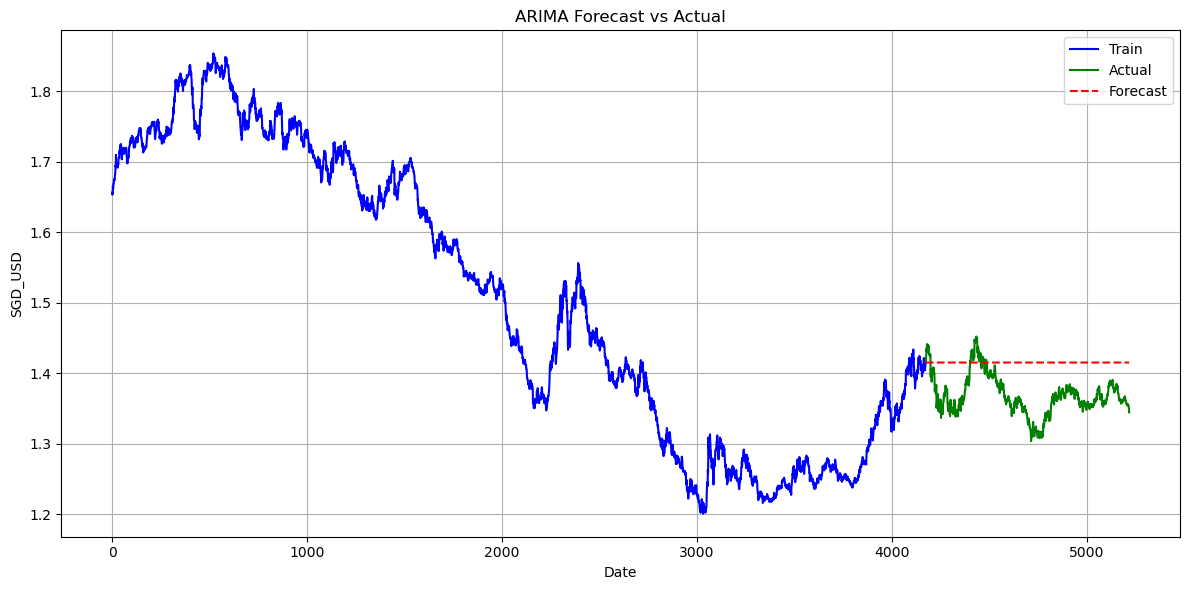

In [24]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

# Fit ARIMA (your original code)
arima_model = pm.auto_arima(
    train[target_col],
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    m=1, d=None, seasonal=False,
    start_P=0, start_Q=0,
    trace=True, error_action='ignore',
    suppress_warnings=True, stepwise=True
)
print(f"Best ARIMA model: {arima_model.order}")

arima = ARIMA(train[target_col], order=arima_model.order)
arima_fit = arima.fit()

# Forecast for the length of the test set
n_periods = len(test)
forecast = arima_fit.forecast(steps=n_periods)

# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(train.index, train[target_col], label='Train', color='blue')
plt.plot(test.index, test[target_col], label='Actual', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red', linestyle='--')

plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### SARIMA MODEL (with seasonality)

Sarima model is recommended for this data it has strong seasonal patterns (clearly visible in the seasonal component).

The seasonal pattern is regular and periodic, which SARIMA models can explicitly account for using seasonal parameters.

SARIMA = ARIMA + Seasonality → perfect match for your time series.

In [25]:
# Example: Assume weekly seasonality (s=5 for business days)
sarima = SARIMAX(
    train[target_col],
    order=arima_model.order,
    seasonal_order=(1, 0, 1, 5)
)
sarima_fit = sarima.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=len(test))


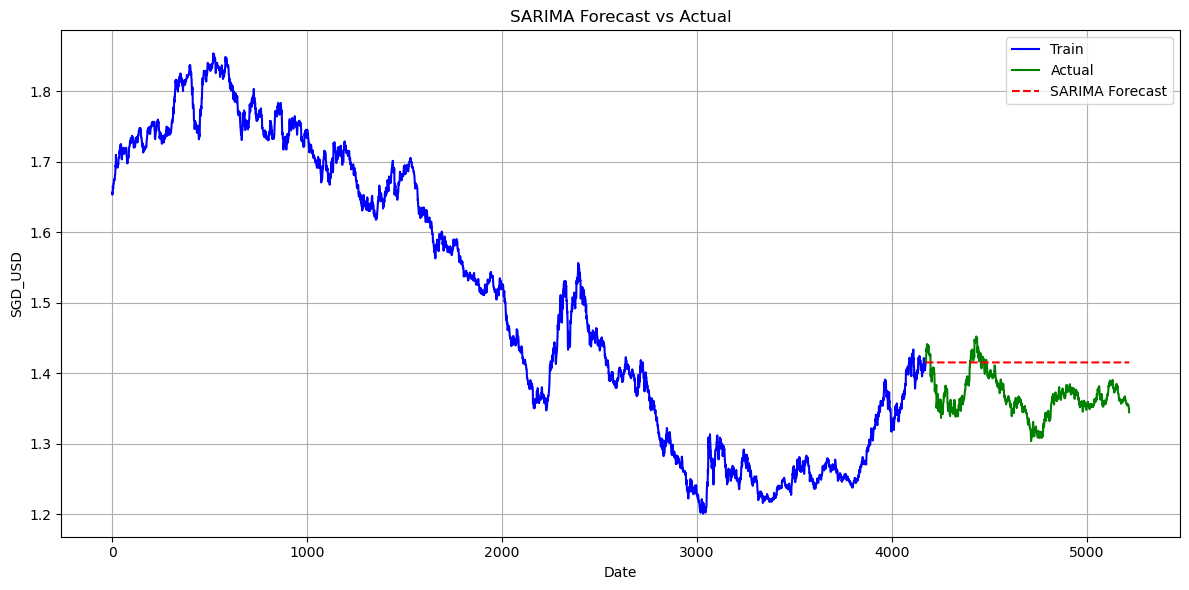

In [26]:
import matplotlib.pyplot as plt

# Plot SARIMA forecast vs actual
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train.index, train[target_col], label='Train', color='blue')

# Plot actual test data
plt.plot(test.index, test[target_col], label='Actual', color='green')

# Plot SARIMA forecast
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='red', linestyle='--')

# Optional: Add title and labels
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Combined Plot: ARIMA vs SARIMA vs Actual

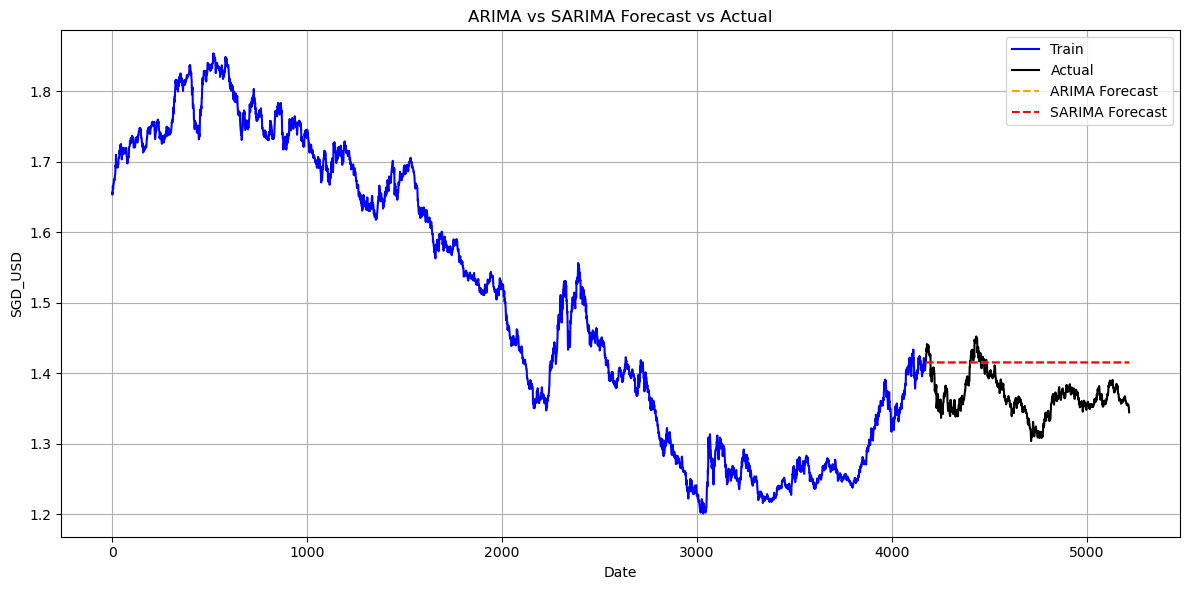

In [27]:
import matplotlib.pyplot as plt

# Forecasts
arima_forecast = arima_fit.forecast(steps=len(test))
sarima_forecast = sarima_fit.forecast(steps=len(test))

# Plot everything
plt.figure(figsize=(12, 6))

# Train data
plt.plot(train.index, train[target_col], label='Train', color='blue')

# Actual test data
plt.plot(test.index, test[target_col], label='Actual', color='black')

# ARIMA forecast
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='orange', linestyle='--')

# SARIMA forecast
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='red', linestyle='--')

# Formatting
plt.title('ARIMA vs SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### XG Boost

In [28]:
# XGBoost
xgb_sgd = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_sgd.fit(X_train, y_train_sgd)
xgb_pred_sgd = xgb_sgd.predict(X_test)

NameError: name 'XGBRegressor' is not defined

In [21]:
# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

# Define target variables and features
targets = ['SGD_USD', 'CNY_USD']
features = [col for col in df.columns if col not in targets + ['DATE']]

# 1. ARIMA Models
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

# Auto ARIMA to find best parameters
arima_sgd = pm.auto_arima(train['SGD_USD'], seasonal=False, stepwise=True)
print(f"Best ARIMA model for SGD/USD: {arima_sgd.order}")
forecast_sgd = arima_sgd.predict(n_periods=len(test))

arima_cny = pm.auto_arima(train['CNY_USD'], seasonal=False, stepwise=True)
print(f"Best ARIMA model for CNY/USD: {arima_cny.order}")
forecast_cny = arima_cny.predict(n_periods=len(test))

# 2. Machine Learning Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prepare training data
X_train = train[features]
y_train_sgd = train['SGD_USD']
y_train_cny = train['CNY_USD']

X_test = test[features]
y_test_sgd = test['SGD_USD']
y_test_cny = test['CNY_USD']

# Random Forest
rf_sgd = RandomForestRegressor(n_estimators=100, random_state=42)
rf_sgd.fit(X_train, y_train_sgd)
rf_pred_sgd = rf_sgd.predict(X_test)

rf_cny = RandomForestRegressor(n_estimators=100, random_state=42)
rf_cny.fit(X_train, y_train_cny)
rf_pred_cny = rf_cny.predict(X_test)

# XGBoost
xgb_sgd = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_sgd.fit(X_train, y_train_sgd)
xgb_pred_sgd = xgb_sgd.predict(X_test)

xgb_cny = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_cny.fit(X_train, y_train_cny)
xgb_pred_cny = xgb_cny.predict(X_test)

Best ARIMA model for SGD/USD: (0, 1, 0)
Best ARIMA model for CNY/USD: (0, 2, 1)


ValueError: at least one array or dtype is required